In [3]:
import pandas as pd
import numpy as np
import os 
import sqlite3
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [4]:
# Set the colour palette to colour-blind friendly
sns.reset_orig()
my_palette = sns.color_palette("colorblind") # variations of default palette: deep, muted, pastel, bright, dark, colorblind. 
plt.style.use('seaborn-colorblind')
# plt.style.available

In [5]:
# Get current working directory
print(os.getcwd())

C:\Users\geral\Repository\Coursework


In [6]:
# Set working directory
os.chdir(r'C:\Users\geral\Repository\Coursework\Dataset')

print(os.getcwd())

C:\Users\geral\Repository\Coursework\Dataset


## Connecting to database

In [7]:
conn = sqlite3.connect('pydatabase.db')

In [8]:
c = conn.cursor()

# 2. Do older planes suffer more delays?

We will proceed by creating a regression model with arrival delay as the dependent variable. A dummy variable "old" will be created, and subsequently we can test the coefficient of the dummy variable to see if it is statistically significant. A significant result would imply that old planes suffer more delays. 

One concern is we do not actually have a variable that indicates whether a plane is or not, hence we will look at the mean / median year of the planes and then determining a suitable year to consider which planes are old.

# Part 1
## Setting up the data
Combining our dataset, Y05_06, with the plane data that shows the year of the plane.

In [7]:
dfA = pd.read_sql_query('''
                SELECT Y05_06.Year, Month, DayofMonth, DayOfWeek, ArrTime, DepTime, CRSArrTime, CRSDepTime, CRSElapsedTime, 
                        UniqueCarrier, Y05_06.TailNum, ArrDelay, DepDelay, Cancelled, Diverted, status, 
                        plane_data.year AS Year_Manufactured
                FROM Y05_06 JOIN plane_data ON Y05_06.TailNum=plane_data.tailnum
                WHERE Cancelled = 0 AND Diverted = 0 AND ArrTime <=2359 AND DepTime <= 2359''', conn)
dfA

,Year,Month,DayofMonth,DayOfWeek,ArrTime,DepTime,CRSArrTime,CRSDepTime,CRSElapsedTime,UniqueCarrier,TailNum,ArrDelay,DepDelay,Cancelled,Diverted,status,Year_Manufactured
0,2005,1,28,5,1741.0,1603.0,1759,1605,174.0,UA,N935UA,-18.0,-2.0,0,0,Valid,1992
1,2005,1,29,6,1736.0,1559.0,1759,1605,174.0,UA,N941UA,-23.0,-6.0,0,0,Valid,1992
2,2005,1,30,7,1741.0,1603.0,1805,1610,175.0,UA,N342UA,-24.0,-7.0,0,0,Valid,1988
3,2005,1,31,1,1726.0,1556.0,1759,1605,174.0,UA,N326UA,-33.0,-9.0,0,0,Valid,1988
4,2005,1,2,7,2235.0,1934.0,2232,1900,152.0,UA,N902UA,3.0,34.0,0,0,Valid,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11177950,2006,12,29,5,1452.0,1246.0,1459,1249,130.0,DL,N905DE,-7.0,-3.0,0,0,Valid,1992
11177951,2006,12,29,5,2033.0,1225.0,1931,1155,276.0,DL,N651DL,62.0,30.0,0,0,Valid,1989
11177952,2006,12,29,5,2254.0,2118.0,2241,2115,86.0,DL,N143DA,13.0,3.0,0,0,Valid,1998
11177953,2006,12,29,5,2209.0,2122.0,2223,2127,116.0,DL,N904DA,-14.0,-5.0,0,0,Valid,1995


In [8]:
dfA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11177955 entries, 0 to 11177954
Data columns (total 17 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   ArrTime            float64
 5   DepTime            float64
 6   CRSArrTime         int64  
 7   CRSDepTime         int64  
 8   CRSElapsedTime     float64
 9   UniqueCarrier      object 
 10  TailNum            object 
 11  ArrDelay           float64
 12  DepDelay           float64
 13  Cancelled          int64  
 14  Diverted           int64  
 15  status             object 
 16  Year_Manufactured  object 
dtypes: float64(5), int64(8), object(4)
memory usage: 1.4+ GB


In [9]:
dfA = dfA.dropna()

dfA.isnull().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
ArrTime              0
DepTime              0
CRSArrTime           0
CRSDepTime           0
CRSElapsedTime       0
UniqueCarrier        0
TailNum              0
ArrDelay             0
DepDelay             0
Cancelled            0
Diverted             0
status               0
Year_Manufactured    0
dtype: int64

In [11]:
dfcarriers = pd.read_sql_query('''SELECT * FROM Carriers''',conn)
dfcarriers

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.
...,...,...
1486,ZW,Air Wisconsin Airlines Corp
1487,ZX,Air Georgian
1488,ZX (1),Airbc Ltd.
1489,ZY,Atlantic Gulf Airlines


In [12]:
df_merged = pd.merge(dfA,dfcarriers, how = 'left', 
                     left_on = 'UniqueCarrier', right_on = 'Code')
df_merged.dropna()
df_merged

,Year,Month,DayofMonth,DayOfWeek,ArrTime,DepTime,CRSArrTime,CRSDepTime,CRSElapsedTime,UniqueCarrier,TailNum,ArrDelay,DepDelay,Cancelled,Diverted,status,Year_Manufactured,Code,Description
0,2005,1,28,5,1741.0,1603.0,1759,1605,174.0,UA,N935UA,-18.0,-2.0,0,0,Valid,1992,UA,United Air Lines Inc.
1,2005,1,29,6,1736.0,1559.0,1759,1605,174.0,UA,N941UA,-23.0,-6.0,0,0,Valid,1992,UA,United Air Lines Inc.
2,2005,1,30,7,1741.0,1603.0,1805,1610,175.0,UA,N342UA,-24.0,-7.0,0,0,Valid,1988,UA,United Air Lines Inc.
3,2005,1,31,1,1726.0,1556.0,1759,1605,174.0,UA,N326UA,-33.0,-9.0,0,0,Valid,1988,UA,United Air Lines Inc.
4,2005,1,2,7,2235.0,1934.0,2232,1900,152.0,UA,N902UA,3.0,34.0,0,0,Valid,1990,UA,United Air Lines Inc.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507939,2006,12,29,5,1452.0,1246.0,1459,1249,130.0,DL,N905DE,-7.0,-3.0,0,0,Valid,1992,DL,Delta Air Lines Inc.
10507940,2006,12,29,5,2033.0,1225.0,1931,1155,276.0,DL,N651DL,62.0,30.0,0,0,Valid,1989,DL,Delta Air Lines Inc.
10507941,2006,12,29,5,2254.0,2118.0,2241,2115,86.0,DL,N143DA,13.0,3.0,0,0,Valid,1998,DL,Delta Air Lines Inc.
10507942,2006,12,29,5,2209.0,2122.0,2223,2127,116.0,DL,N904DA,-14.0,-5.0,0,0,Valid,1995,DL,Delta Air Lines Inc.


In [13]:
df_merged.drop(df_merged[df_merged['Year_Manufactured'] == 'None'].index, inplace = True)
df_merged.drop(df_merged[df_merged['Year_Manufactured'] == '0000'].index, inplace = True)

# q2_df.drop(q2_df[q2_df['Built_Year'] == "None"].index, inplace = True)
# q2_df['Built_Year'] = pd.to_numeric(sample_df['Built_Year'])

In [14]:
# To check for missing values 
df_merged.isnull().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
ArrTime              0
DepTime              0
CRSArrTime           0
CRSDepTime           0
CRSElapsedTime       0
UniqueCarrier        0
TailNum              0
ArrDelay             0
DepDelay             0
Cancelled            0
Diverted             0
status               0
Year_Manufactured    0
Code                 0
Description          0
dtype: int64

In [15]:
np.unique(df_merged['Year_Manufactured'])

array(['1956', '1957', '1959', '1962', '1963', '1964', '1965', '1966',
       '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007'],
      dtype=object)

Creating a new column called age by taking Year - Year_Manufactured.

In [16]:
df_merged['Year_Manufactured'] = df_merged['Year_Manufactured'].astype(int) 

Y05_06_nage = df_merged.copy()

Y05_06_nage.info()

# observations : 10209581  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10209581 entries, 0 to 10507943
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   ArrTime            float64
 5   DepTime            float64
 6   CRSArrTime         int64  
 7   CRSDepTime         int64  
 8   CRSElapsedTime     float64
 9   UniqueCarrier      object 
 10  TailNum            object 
 11  ArrDelay           float64
 12  DepDelay           float64
 13  Cancelled          int64  
 14  Diverted           int64  
 15  status             object 
 16  Year_Manufactured  int32  
 17  Code               object 
 18  Description        object 
dtypes: float64(5), int32(1), int64(8), object(5)
memory usage: 1.5+ GB


In [17]:
Y05_06_nage = Y05_06_nage.assign(Age = Y05_06_nage.Year - Y05_06_nage.Year_Manufactured)
Y05_06_nage.info()
Y05_06_nage

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10209581 entries, 0 to 10507943
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   ArrTime            float64
 5   DepTime            float64
 6   CRSArrTime         int64  
 7   CRSDepTime         int64  
 8   CRSElapsedTime     float64
 9   UniqueCarrier      object 
 10  TailNum            object 
 11  ArrDelay           float64
 12  DepDelay           float64
 13  Cancelled          int64  
 14  Diverted           int64  
 15  status             object 
 16  Year_Manufactured  int32  
 17  Code               object 
 18  Description        object 
 19  Age                int64  
dtypes: float64(5), int32(1), int64(9), object(5)
memory usage: 1.6+ GB


,Year,Month,DayofMonth,DayOfWeek,ArrTime,DepTime,CRSArrTime,CRSDepTime,CRSElapsedTime,UniqueCarrier,TailNum,ArrDelay,DepDelay,Cancelled,Diverted,status,Year_Manufactured,Code,Description,Age
0,2005,1,28,5,1741.0,1603.0,1759,1605,174.0,UA,N935UA,-18.0,-2.0,0,0,Valid,1992,UA,United Air Lines Inc.,13
1,2005,1,29,6,1736.0,1559.0,1759,1605,174.0,UA,N941UA,-23.0,-6.0,0,0,Valid,1992,UA,United Air Lines Inc.,13
2,2005,1,30,7,1741.0,1603.0,1805,1610,175.0,UA,N342UA,-24.0,-7.0,0,0,Valid,1988,UA,United Air Lines Inc.,17
3,2005,1,31,1,1726.0,1556.0,1759,1605,174.0,UA,N326UA,-33.0,-9.0,0,0,Valid,1988,UA,United Air Lines Inc.,17
4,2005,1,2,7,2235.0,1934.0,2232,1900,152.0,UA,N902UA,3.0,34.0,0,0,Valid,1990,UA,United Air Lines Inc.,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507939,2006,12,29,5,1452.0,1246.0,1459,1249,130.0,DL,N905DE,-7.0,-3.0,0,0,Valid,1992,DL,Delta Air Lines Inc.,14
10507940,2006,12,29,5,2033.0,1225.0,1931,1155,276.0,DL,N651DL,62.0,30.0,0,0,Valid,1989,DL,Delta Air Lines Inc.,17
10507941,2006,12,29,5,2254.0,2118.0,2241,2115,86.0,DL,N143DA,13.0,3.0,0,0,Valid,1998,DL,Delta Air Lines Inc.,8
10507942,2006,12,29,5,2209.0,2122.0,2223,2127,116.0,DL,N904DA,-14.0,-5.0,0,0,Valid,1995,DL,Delta Air Lines Inc.,11


Creating a table on db browser, so that subsequently we can extract directly from the database. 

In [18]:
c.execute(''' DROP TABLE Q2''')

Y05_06_nage.to_sql('Q2', con = conn, index = False)

In [19]:
# to free up memory
del dfA, dfcarriers, df_merged, Y05_06_nage

# Part 2
To check the number of flights by the Year_Manufactured (Age)

In [29]:
years_count = pd.read_sql_query('''
SELECT year_manufactured, Age, COUNT(year_manufactured) AS Count
FROM Q2
WHERE year_manufactured != 'NA' AND year_manufactured != '0000' AND year_manufactured != 'None' 
AND Age >= '0' AND Age != 'NA' AND Age != 'na'
AND DepDelay != 'NA' AND ArrDelay != 'NA'
AND status != 'Registered to Mfr' AND status != 'NA'
GROUP BY year_manufactured, Age''',conn)

years_count

# observations : 10,205,851

,Year_Manufactured,Age,Count
0,1956,49,252
1,1956,50,292
2,1957,48,1157
3,1957,49,947
4,1959,46,2451
...,...,...,...
88,2004,1,277150
89,2004,2,318895
90,2005,0,120207
91,2005,1,265591


In [21]:
# to check the total number of flights 
years_count['Count'].sum()

10205851

In [22]:
years_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Year_Manufactured  93 non-null     int64
 1   Age                93 non-null     int64
 2   Count              93 non-null     int64
dtypes: int64(3)
memory usage: 2.3 KB


In [23]:
# to find the MIN, MAX, AVERAGE
sum_years = pd.read_sql_query('''
SELECT MIN(year_manufactured), MAX(year_manufactured), 
AVG(year_manufactured)
FROM Q2
WHERE year_manufactured != 'NA' AND year_manufactured != '0000' AND year_manufactured != 'None' 
AND Age >= '0' AND Age != 'NA' AND Age != 'na'
AND DepDelay != 'NA' AND ArrDelay != 'NA'
AND status != 'Registered to Mfr' AND status != 'NA'
''',conn)

sum_years

,MIN(year_manufactured),MAX(year_manufactured),AVG(year_manufactured)
0,1956,2006,1996.405571


From the above we observe that our mean year is 1996. 

In [24]:
del years_count, sum_years

## Tidying up the data

We take the mean as 1996, so planes earlier than 1996 (included) is considered old. 
We remove from the dataset, observations that contains NA & 0.

In [9]:
A = pd.read_sql_query('''
SELECT ArrDelay, DepDelay, CRSArrTime, CRSDepTime, CRSElapsedTime, Month, DayofMonth, DayOfWeek, Age, Year_Manufactured, status, Cancelled, Diverted
FROM Q2
WHERE year_manufactured != 'NA' AND year_manufactured != '0000' AND year_manufactured != 'None' 
AND Age >= '0' AND Age != 'NA' AND Age != 'na'
AND DepDelay != 'NA' AND ArrDelay != 'NA'
AND status != 'Registered to Mfr' AND status != 'NA'
''',conn)
A

,ArrDelay,DepDelay,CRSArrTime,CRSDepTime,CRSElapsedTime,Month,DayofMonth,DayOfWeek,Age,Year_Manufactured,status,Cancelled,Diverted
0,-18.0,-2.0,1759,1605,174.0,1,28,5,13,1992,Valid,0,0
1,-23.0,-6.0,1759,1605,174.0,1,29,6,13,1992,Valid,0,0
2,-24.0,-7.0,1805,1610,175.0,1,30,7,17,1988,Valid,0,0
3,-33.0,-9.0,1759,1605,174.0,1,31,1,17,1988,Valid,0,0
4,3.0,34.0,2232,1900,152.0,1,2,7,15,1990,Valid,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10205846,-7.0,-3.0,1459,1249,130.0,12,29,5,14,1992,Valid,0,0
10205847,62.0,30.0,1931,1155,276.0,12,29,5,17,1989,Valid,0,0
10205848,13.0,3.0,2241,2115,86.0,12,29,5,8,1998,Valid,0,0
10205849,-14.0,-5.0,2223,2127,116.0,12,29,5,11,1995,Valid,0,0


In [10]:
A.info()

# Observations : 10,219,906 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10205851 entries, 0 to 10205850
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ArrDelay           float64
 1   DepDelay           float64
 2   CRSArrTime         int64  
 3   CRSDepTime         int64  
 4   CRSElapsedTime     float64
 5   Month              int64  
 6   DayofMonth         int64  
 7   DayOfWeek          int64  
 8   Age                int64  
 9   Year_Manufactured  int64  
 10  status             object 
 11  Cancelled          int64  
 12  Diverted           int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 1012.2+ MB


Creating a function to recode the dummy variables

In [11]:
def DV(Age):
    '''
    We create a fuunction for the creation of dummy variables. 
    For planes with the age of 10 and more or Year_Manufactured <= 1996 are considered old.
    Hence Old = 1, 0 otherwise.
    '''
    if (Age >= 10):
        return '1'
    else:
        return '0'
    

In [12]:
A['Old'] = A['Age'].apply(DV)
A

,ArrDelay,DepDelay,CRSArrTime,CRSDepTime,CRSElapsedTime,Month,DayofMonth,DayOfWeek,Age,Year_Manufactured,status,Cancelled,Diverted,Old
0,-18.0,-2.0,1759,1605,174.0,1,28,5,13,1992,Valid,0,0,1
1,-23.0,-6.0,1759,1605,174.0,1,29,6,13,1992,Valid,0,0,1
2,-24.0,-7.0,1805,1610,175.0,1,30,7,17,1988,Valid,0,0,1
3,-33.0,-9.0,1759,1605,174.0,1,31,1,17,1988,Valid,0,0,1
4,3.0,34.0,2232,1900,152.0,1,2,7,15,1990,Valid,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10205846,-7.0,-3.0,1459,1249,130.0,12,29,5,14,1992,Valid,0,0,1
10205847,62.0,30.0,1931,1155,276.0,12,29,5,17,1989,Valid,0,0,1
10205848,13.0,3.0,2241,2115,86.0,12,29,5,8,1998,Valid,0,0,0
10205849,-14.0,-5.0,2223,2127,116.0,12,29,5,11,1995,Valid,0,0,1


In [13]:
A['Old'] = A['Old'].astype('int64')

In [14]:
A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10205851 entries, 0 to 10205850
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ArrDelay           float64
 1   DepDelay           float64
 2   CRSArrTime         int64  
 3   CRSDepTime         int64  
 4   CRSElapsedTime     float64
 5   Month              int64  
 6   DayofMonth         int64  
 7   DayOfWeek          int64  
 8   Age                int64  
 9   Year_Manufactured  int64  
 10  status             object 
 11  Cancelled          int64  
 12  Diverted           int64  
 13  Old                int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 1.1+ GB


Checking the count of the old planes

In [15]:
check_old = A[['Old']]
check_old = check_old.groupby(by = 'Old')
check_old = (check_old.agg({'Old':'count'}))
check_old

,Old
Old,
0,6413027
1,3792824


In [16]:
A.isnull().sum()

ArrDelay             0
DepDelay             0
CRSArrTime           0
CRSDepTime           0
CRSElapsedTime       0
Month                0
DayofMonth           0
DayOfWeek            0
Age                  0
Year_Manufactured    0
status               0
Cancelled            0
Diverted             0
Old                  0
dtype: int64

In [17]:
A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10205851 entries, 0 to 10205850
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ArrDelay           float64
 1   DepDelay           float64
 2   CRSArrTime         int64  
 3   CRSDepTime         int64  
 4   CRSElapsedTime     float64
 5   Month              int64  
 6   DayofMonth         int64  
 7   DayOfWeek          int64  
 8   Age                int64  
 9   Year_Manufactured  int64  
 10  status             object 
 11  Cancelled          int64  
 12  Diverted           int64  
 13  Old                int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 1.1+ GB


Checking the quantile & correlation

In [18]:
A['DepDelay'].quantile([0.001, 0.25, 0.5, 0.75, 0.999])

0.001    -17.0
0.250     -4.0
0.500      0.0
0.750      8.0
0.999    303.0
Name: DepDelay, dtype: float64

In [19]:
# Look at planes in the 0.1 percentile and beyond the 99.9 percentile
# 0.1% 
check1 = A[(A['DepDelay'] < - 17)].sort_values(by = 'DepDelay')

# changing Old
check1['Old'] = check1['Old'].astype('object')
check1

# observations : 7576 

,ArrDelay,DepDelay,CRSArrTime,CRSDepTime,CRSElapsedTime,Month,DayofMonth,DayOfWeek,Age,Year_Manufactured,status,Cancelled,Diverted,Old
7876409,257.0,-1200.0,2320,2130,110.0,7,21,5,1,2005,Valid,0,0,0
334146,234.0,-1199.0,2355,2235,80.0,1,23,7,1,2004,Valid,0,0,0
3218782,269.0,-1199.0,2315,2110,185.0,8,14,7,2,2003,Valid,0,0,0
7410984,249.0,-1199.0,800,2355,305.0,6,1,4,2,2004,Valid,0,0,0
334269,236.0,-1199.0,2130,2005,85.0,1,24,1,3,2002,Valid,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7691896,-11.0,-18.0,1608,1500,68.0,7,8,6,15,1991,Valid,0,0,1
5439297,-5.0,-18.0,1355,1215,100.0,2,14,2,8,1998,Valid,0,0,0
5436995,-14.0,-18.0,1425,1308,77.0,2,28,2,3,2003,Valid,0,0,0
968282,-29.0,-18.0,2249,2032,77.0,3,19,6,4,2001,Valid,0,0,0


In [20]:
# beyond 99.9
check2 = A[(A['DepDelay'] > 304)].sort_values(by = 'DepDelay')

check2['Old'] = check2['Old'].astype('object')
check2

# observations : 10150 

,ArrDelay,DepDelay,CRSArrTime,CRSDepTime,CRSElapsedTime,Month,DayofMonth,DayOfWeek,Age,Year_Manufactured,status,Cancelled,Diverted,Old
747695,281.0,305.0,2247,1800,167.0,2,16,3,13,1992,Valid,0,0,1
4959830,319.0,305.0,1351,1220,91.0,1,2,1,6,2000,Valid,0,0,0
163620,303.0,305.0,1429,1320,69.0,1,13,4,2,2003,Valid,0,0,0
2437678,309.0,305.0,1013,837,156.0,7,1,5,18,1987,Valid,0,0,1
2672235,305.0,305.0,1629,1330,119.0,7,15,5,5,2000,Valid,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395080,1639.0,1659.0,1207,630,217.0,11,2,3,4,2001,Valid,0,0,0
7794338,1691.0,1666.0,1610,1307,183.0,7,19,3,14,1992,Valid,0,0,1
452919,1667.0,1676.0,1738,1455,283.0,2,26,6,14,1991,Valid,0,0,1
2499701,1735.0,1732.0,1706,1410,116.0,7,21,4,32,1973,Valid,0,0,1


[Text(0.5, 0, 'Departure Delay'),
 Text(0, 0.5, 'Arrival Delay'),
 Text(0.5, 1.0, 'Arrival vs Departure Delay (99.9 Percentile)')]

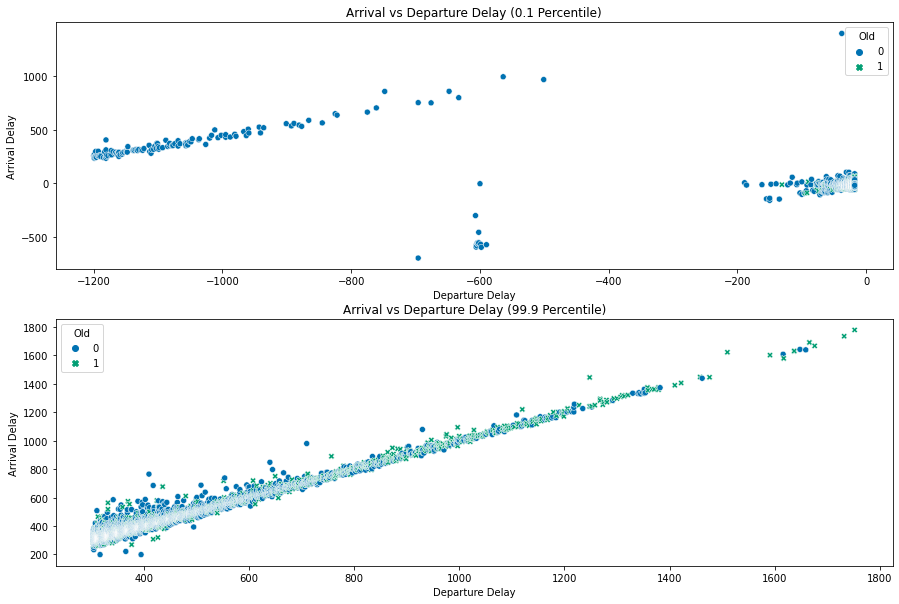

In [21]:
# plot
fig, ax = plt.subplots(2, figsize = (15,10))

# 0.1 percentile
sns.scatterplot(data = check1, x = 'DepDelay', y = 'ArrDelay', ax = ax[0], hue = 'Old', style = 'Old')
ax[0].set(xlabel='Departure Delay',
       ylabel='Arrival Delay',
       title='Arrival vs Departure Delay (0.1 Percentile)')

# 99.9 percentile
sns.scatterplot(data = check2, x = 'DepDelay', y = 'ArrDelay', ax = ax[1], hue = 'Old', style = 'Old')
ax[1].set(xlabel='Departure Delay',
       ylabel='Arrival Delay',
       title='Arrival vs Departure Delay (99.9 Percentile)')

We observe that in the 0.1 percentile chart, there are extreme values, consider the following where departure delay is less than 500 minutes while arrival delay is around 250 minutes and above. Which implies that a plane which departs early by more than 8 hours (500 mins), can still arrive late by about 4 hours (250mins) or more. This does not make sense hence we will remove data of planes with departure delay below -250. 

In [22]:
Final = A[(A['DepDelay'] > -250)]
Final = Final[['ArrDelay', 'DepDelay', 'CRSArrTime', 'CRSDepTime', 'CRSElapsedTime', 'Month', 'DayofMonth', 'DayofMonth', 
               'DayOfWeek', 'Age', 'Year_Manufactured', 'Old']]
Final

# observation : 10,219,758 

,ArrDelay,DepDelay,CRSArrTime,CRSDepTime,CRSElapsedTime,Month,DayofMonth,DayofMonth,DayOfWeek,Age,Year_Manufactured,Old
0,-18.0,-2.0,1759,1605,174.0,1,28,28,5,13,1992,1
1,-23.0,-6.0,1759,1605,174.0,1,29,29,6,13,1992,1
2,-24.0,-7.0,1805,1610,175.0,1,30,30,7,17,1988,1
3,-33.0,-9.0,1759,1605,174.0,1,31,31,1,17,1988,1
4,3.0,34.0,2232,1900,152.0,1,2,2,7,15,1990,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10205846,-7.0,-3.0,1459,1249,130.0,12,29,29,5,14,1992,1
10205847,62.0,30.0,1931,1155,276.0,12,29,29,5,17,1989,1
10205848,13.0,3.0,2241,2115,86.0,12,29,29,5,8,1998,0
10205849,-14.0,-5.0,2223,2127,116.0,12,29,29,5,11,1995,1


### Correlation

In [23]:
corrMatrix = Final.corr()
print (corrMatrix)

                   ArrDelay  DepDelay  CRSArrTime  CRSDepTime  CRSElapsedTime  \
ArrDelay           1.000000  0.923394    0.131489    0.133893       -0.001696   
DepDelay           0.923394  1.000000    0.141561    0.148334        0.014407   
CRSArrTime         0.131489  0.141561    1.000000    0.776329        0.048854   
CRSDepTime         0.133893  0.148334    0.776329    1.000000       -0.008677   
CRSElapsedTime    -0.001696  0.014407    0.048854   -0.008677        1.000000   
Month              0.019914  0.016429   -0.004200   -0.005604        0.002509   
DayofMonth         0.018470  0.018613   -0.001245   -0.000986        0.001195   
DayofMonth         0.018470  0.018613   -0.001245   -0.000986        0.001195   
DayOfWeek         -0.006882  0.004714    0.004515    0.004666        0.011226   
Age                0.003904 -0.001370    0.018129    0.003670        0.017992   
Year_Manufactured -0.002164  0.003008   -0.018561   -0.004079       -0.017632   
Old                0.003740 

## Regression Model

Performing a linear regression of Arrival delay on departure delay, year manufactured and old to find the significance of old planes and departure delays.

In [24]:
Final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10205708 entries, 0 to 10205850
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ArrDelay           float64
 1   DepDelay           float64
 2   CRSArrTime         int64  
 3   CRSDepTime         int64  
 4   CRSElapsedTime     float64
 5   Month              int64  
 6   DayofMonth         int64  
 7   DayofMonth         int64  
 8   DayOfWeek          int64  
 9   Age                int64  
 10  Year_Manufactured  int64  
 11  Old                int64  
dtypes: float64(3), int64(9)
memory usage: 1012.2 MB


In [25]:
result = smf.ols('ArrDelay ~ DepDelay + CRSArrTime + CRSDepTime + Old', data = Final).fit()
result.params 

Intercept    -1.130371
DepDelay      1.019633
CRSArrTime    0.000594
CRSDepTime   -0.000716
Old          -0.004033
dtype: float64

In [26]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               ArrDelay   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                 1.477e+07
Date:                Sun, 20 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:22:58   Log-Likelihood:            -4.1236e+07
No. Observations:            10205708   AIC:                         8.247e+07
Df Residuals:                10205703   BIC:                         8.247e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1304      0.015    -76.531      0.0

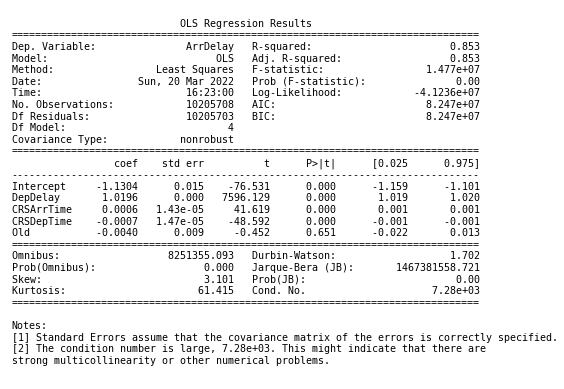

In [27]:
plt.rc('figure', figsize=(8, 6))
plt.text(0.01, 0.05, str(result.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('pyq2regresult.jpg')

## Bar chart of the count of planes each year

In [30]:
years_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Year_Manufactured  93 non-null     int64
 1   Age                93 non-null     int64
 2   Count              93 non-null     int64
dtypes: int64(3)
memory usage: 2.3 KB


Text(0, 0.5, 'Count')

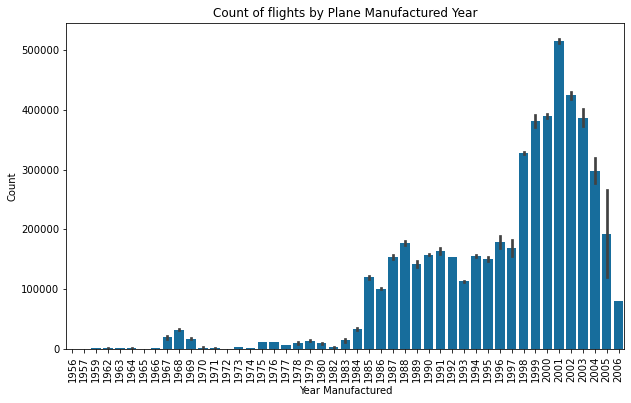

In [31]:
fig, ax = plt.subplots(figsize=(10,6))

sns.barplot(x = 'Year_Manufactured', y = 'Count', data = years_count, 
            color = my_palette[0])

ax.title.set_text('Count of flights by Plane Manufactured Year')
ax.set_xlabel('Year Manufactured')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel('Count')

### Disconnecting from DB

In [32]:
conn.close()